In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [3]:

#reading the file
train = pd.read_csv('/home/rhythm/Research/ml/research-costh/dataset/train.csv', delimiter=";", header = 0)

In [4]:
train.describe()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
count,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001,50001
unique,50001,23429,25600,23452,25622,23658,23682,106,25894,25894,104,49457
top,0,0,0,-5e-09,-5e-09,-0.0640809,-0.0124847,2.20001,0.0417985,-0.0206471,-2.20001,-0.965462
freq,1,26154,23869,26154,23869,17,17,5872,15,15,5579,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   evt     50001 non-null  object
 1   E1      50001 non-null  object
 2   E2      50001 non-null  object
 3   t1      50001 non-null  object
 4   t2      50001 non-null  object
 5   x1      50001 non-null  object
 6   y1      50001 non-null  object
 7   z1      50001 non-null  object
 8   x2      50001 non-null  object
 9   y2      50001 non-null  object
 10  z2      50001 non-null  object
 11  costh   50001 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


In [4]:
for cols in train.columns :
    train[cols] = pd.to_numeric(train[cols], errors='coerce')
    

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evt     50000 non-null  float64
 1   E1      50000 non-null  float64
 2   E2      50000 non-null  float64
 3   t1      50000 non-null  float64
 4   t2      50000 non-null  float64
 5   x1      50000 non-null  float64
 6   y1      50000 non-null  float64
 7   z1      50000 non-null  float64
 8   x2      50000 non-null  float64
 9   y2      50000 non-null  float64
 10  z2      50000 non-null  float64
 11  costh   50000 non-null  float64
dtypes: float64(12)
memory usage: 4.6 MB


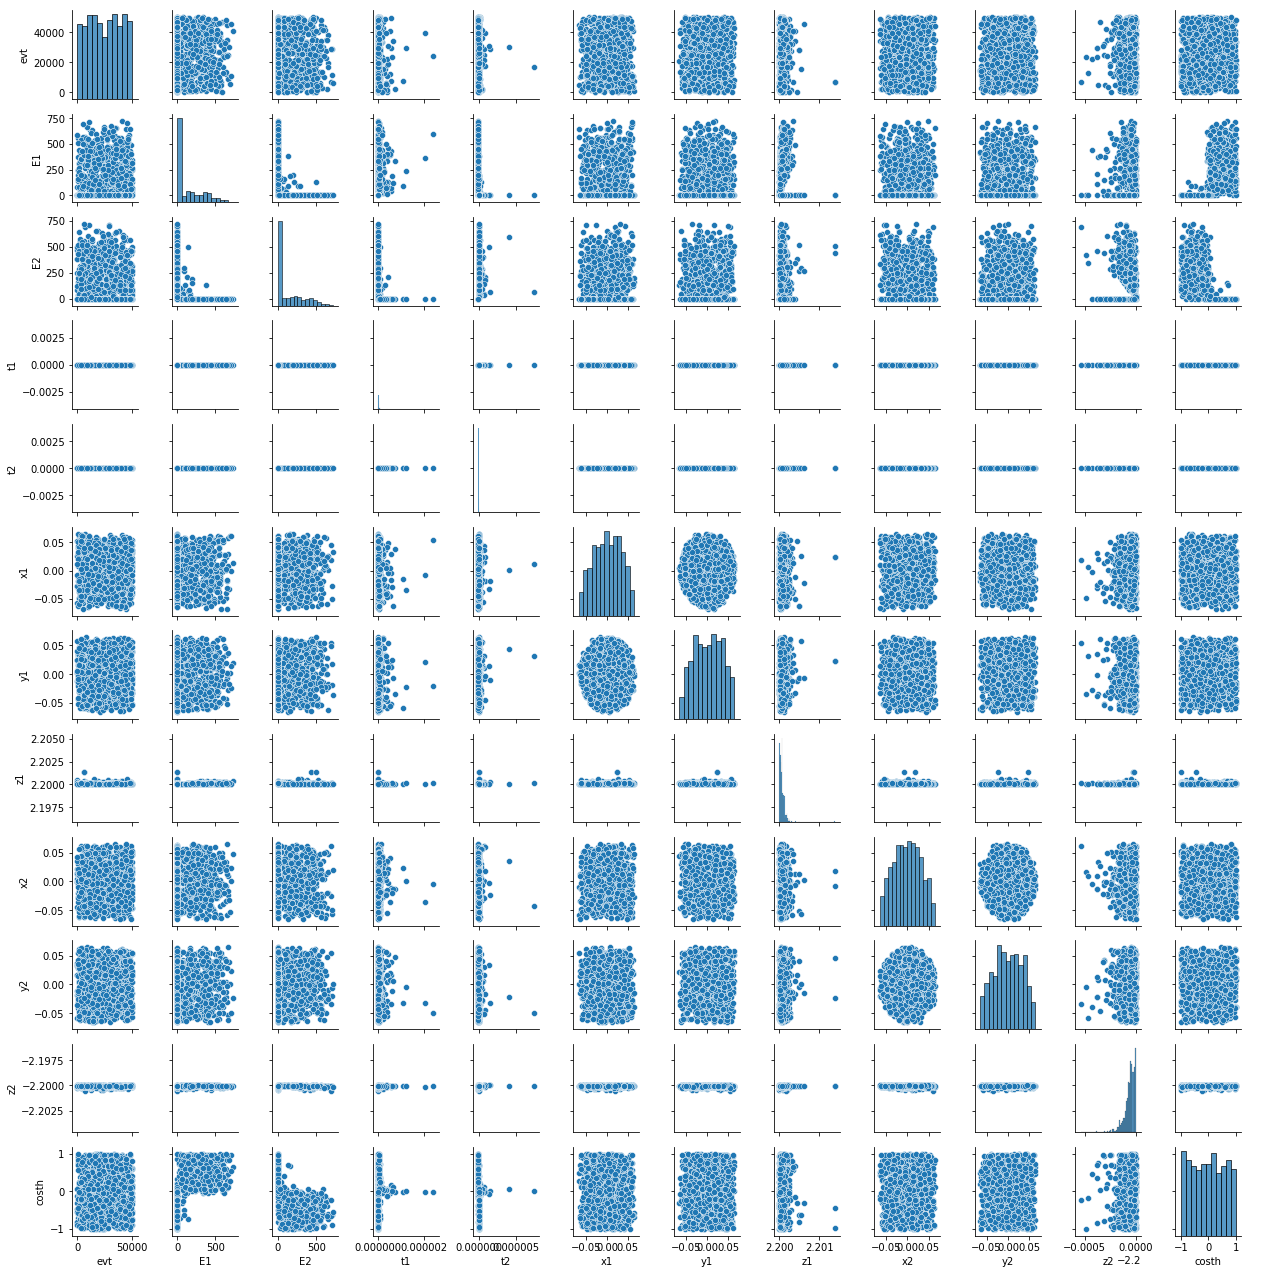

In [7]:
sns.pairplot(data = train.sample(1000), height = 1.5)

In [7]:
corr = train.corr()

[Text(0.5, 0, 'evt'),
 Text(1.5, 0, 'E1'),
 Text(2.5, 0, 'E2'),
 Text(3.5, 0, 't1'),
 Text(4.5, 0, 't2'),
 Text(5.5, 0, 'x1'),
 Text(6.5, 0, 'y1'),
 Text(7.5, 0, 'z1'),
 Text(8.5, 0, 'x2'),
 Text(9.5, 0, 'y2'),
 Text(10.5, 0, 'z2'),
 Text(11.5, 0, 'costh')]

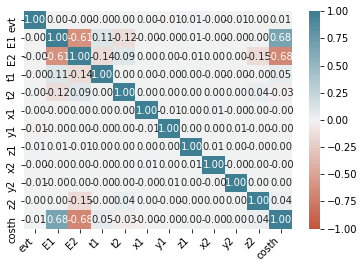

In [14]:
#let's look at the correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot = True, fmt =".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [5]:
train.describe()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
count,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,138.812983,154.750947,3.091173e-08,3.429387e-08,0.000146,0.000509,2.199936,-0.000349,-0.000015,-2.200070,-0.029850
std,14433.901067,183.105329,188.490537,2.003470e-07,2.263487e-07,0.032236,0.032361,0.017042,0.032346,0.032321,0.000088,0.575545
min,0.000000,0.000000,0.000000,-5.000000e-09,-5.000000e-09,-0.068426,-0.071451,0.000000,-0.068151,-0.069590,-2.203460,-0.999928
25%,12499.750000,0.000000,0.000000,-5.000000e-09,-5.000000e-09,-0.025825,-0.025543,2.200020,-0.026362,-0.025934,-2.200090,-0.528981
50%,24999.500000,0.000000,51.375450,-5.000000e-09,5.324195e-09,0.000318,0.000434,2.200050,-0.000176,-0.000019,-2.200050,-0.044429
75%,37499.250000,266.469000,292.817500,1.876462e-08,1.954730e-08,0.026143,0.026954,2.200090,0.025677,0.026214,-2.200030,0.463040
max,49999.000000,757.665000,751.302000,7.279570e-06,9.908810e-06,0.069265,0.068058,2.203460,0.068935,0.067699,-2.200000,0.999965


In [5]:
train['t1'] = train.t1.replace(-5.000000e-09, 0)
train['t2'] = train.t2.replace(-5.000000e-09, 0)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evt     50000 non-null  float64
 1   E1      50000 non-null  float64
 2   E2      50000 non-null  float64
 3   t1      50000 non-null  float64
 4   t2      50000 non-null  float64
 5   x1      50000 non-null  float64
 6   y1      50000 non-null  float64
 7   z1      50000 non-null  float64
 8   x2      50000 non-null  float64
 9   y2      50000 non-null  float64
 10  z2      50000 non-null  float64
 11  costh   50000 non-null  float64
dtypes: float64(12)
memory usage: 4.6 MB


In [5]:
train.describe()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
count,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,138.812983,154.750947,3.352713e-08,3.668077e-08,0.000146,0.000509,2.199936,-0.000349,-0.000015,-2.200070,-0.029850
std,14433.901067,183.105329,188.490537,1.998932e-07,2.259477e-07,0.032236,0.032361,0.017042,0.032346,0.032321,0.000088,0.575545
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.068426,-0.071451,0.000000,-0.068151,-0.069590,-2.203460,-0.999928
25%,12499.750000,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.025825,-0.025543,2.200020,-0.026362,-0.025934,-2.200090,-0.528981
50%,24999.500000,0.000000,51.375450,0.000000e+00,5.324195e-09,0.000318,0.000434,2.200050,-0.000176,-0.000019,-2.200050,-0.044429
75%,37499.250000,266.469000,292.817500,1.876462e-08,1.954730e-08,0.026143,0.026954,2.200090,0.025677,0.026214,-2.200030,0.463040
max,49999.000000,757.665000,751.302000,7.279570e-06,9.908810e-06,0.069265,0.068058,2.203460,0.068935,0.067699,-2.200000,0.999965


graphical representation of the featues 

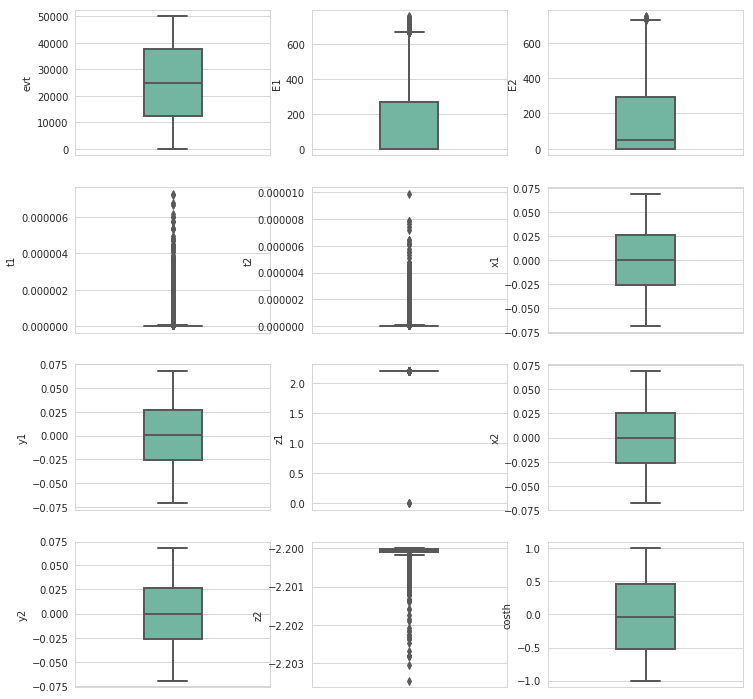

In [59]:
fig,ax = plt.subplots(4,3, figsize = (10,12))
ax = ax.flatten()
for i, col in enumerate(train.columns):
    sns.set_style("whitegrid",{'axes.grid':True} )
    sns.boxplot(y = train[col], width = 0.3, ax=ax[i], palette="Set2", linewidth=2, 
                dodge = False)
fig.tight_layout()
    


In [11]:
# number of features 
p = train.shape[1]
display(p-1)

11

In [6]:
X = train.drop('costh', axis =1 )
y = train['costh']
train.isna().sum()
train

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2,costh
0,0.0,0.000,533.096,0.000000e+00,2.811460e-08,0.000000,0.000000,0.00000,-0.030565,-0.054457,-2.20005,-0.348747
1,1.0,0.000,139.475,0.000000e+00,1.750150e-08,0.000000,0.000000,0.00000,-0.043051,-0.001715,-2.20001,-0.267086
2,2.0,300.018,0.000,9.764160e-09,0.000000e+00,0.012678,0.022999,2.20007,-0.043051,-0.001715,-2.20001,0.600994
3,3.0,0.000,293.637,0.000000e+00,4.973400e-08,0.012678,0.022999,2.20007,-0.010792,-0.043525,-2.20005,-0.116312
4,4.0,159.739,0.000,6.008920e-09,0.000000e+00,-0.030505,-0.051298,2.20001,-0.010792,-0.043525,-2.20005,0.561788
...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49995.0,210.042,0.000,1.776630e-08,0.000000e+00,0.051133,-0.039178,2.20004,0.046106,0.032766,-2.20009,0.407716
49997,49996.0,459.492,0.000,5.384680e-09,0.000000e+00,-0.034479,0.044191,2.20018,0.046106,0.032766,-2.20009,0.579480
49998,49997.0,259.989,0.000,1.994870e-08,0.000000e+00,-0.010198,-0.000332,2.20007,0.046106,0.032766,-2.20009,0.764000
49999,49998.0,0.000,81.079,0.000000e+00,1.369200e-08,-0.010198,-0.000332,2.20007,0.051597,-0.002169,-2.20005,-0.982856


In [7]:
train = train.dropna()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evt     50000 non-null  float64
 1   E1      50000 non-null  float64
 2   E2      50000 non-null  float64
 3   t1      50000 non-null  float64
 4   t2      50000 non-null  float64
 5   x1      50000 non-null  float64
 6   y1      50000 non-null  float64
 7   z1      50000 non-null  float64
 8   x2      50000 non-null  float64
 9   y2      50000 non-null  float64
 10  z2      50000 non-null  float64
 11  costh   50000 non-null  float64
dtypes: float64(12)
memory usage: 5.0 MB


In [21]:
#splitting into validation and training dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_Val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [30]:
#scale the variables
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_std = sc.fit_transform(X_train)
y_train_std = sc.fit_transform(y_train.values.reshape(-1, 1))
X_val_std = sc.transform(X_val)
#X_train_std.dropna()


In [27]:
cols_name = [cols for cols in X.columns]
X_train_std_df = pd.DataFrame(data = X_train_std,columns = cols_name )
X_train_std_df.dropna()

,evt,E1,E2,t1,t2,x1,y1,z1,x2,y2,z2
0,1.080189,-0.755329,-0.823123,-0.172343,-0.167552,2.001319,-0.207793,0.008022,-0.979068,1.858247,0.446667
1,1.690687,-0.755329,0.933128,-0.172343,-0.138270,0.561047,1.197793,0.002920,-1.744384,-0.711097,-0.112914
2,0.741024,-0.755329,0.037911,-0.172343,-0.124636,0.719229,0.917923,0.000369,-0.356254,-0.417480,-7.051710
3,1.155444,1.049570,-0.823123,0.836614,-0.167552,0.253669,1.257290,0.002069,1.690197,0.740976,-8.954283
4,0.424886,-0.755329,-0.359895,-0.172343,-0.000219,0.815831,-0.118078,0.002069,-0.188620,-0.320540,0.334751
...,...,...,...,...,...,...,...,...,...,...,...
34995,-0.954734,-0.303432,-0.823123,0.440331,-0.167552,-1.526403,1.110871,0.002069,0.953266,-1.307174,-1.008242
34996,1.365116,0.338453,-0.823123,0.096038,-0.167552,0.068373,0.037574,0.002920,1.589011,0.784102,-0.112914
34997,0.909150,-0.205096,-0.823123,-0.129907,-0.167552,0.101545,-0.859365,0.000369,0.584498,1.775346,-0.560578
34998,-1.677732,-0.755329,0.241812,-0.172343,-0.111385,0.874980,1.405885,0.002069,-0.820585,-1.058749,0.558583


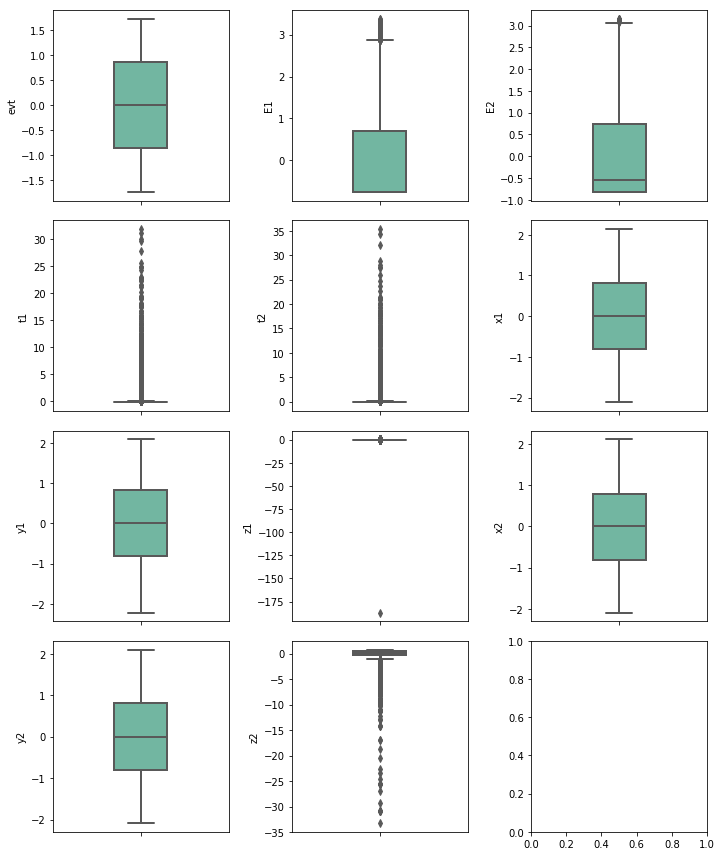

In [24]:
fig,ax = plt.subplots(4,3, figsize = (10,12))
ax = ax.flatten()
for i, col in enumerate(X_train_std_df.columns):
    sns.set_style("whitegrid",{'axes.grid':True} )
    sns.boxplot(y = X_train_std_df[col], width = 0.3, ax=ax[i], palette="Set2", linewidth=2, 
                dodge = False)
fig.tight_layout()


In [28]:
#Linear Regression
#from locale import normalize
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train_std)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [42]:
corr_std = X_std_df.corr()

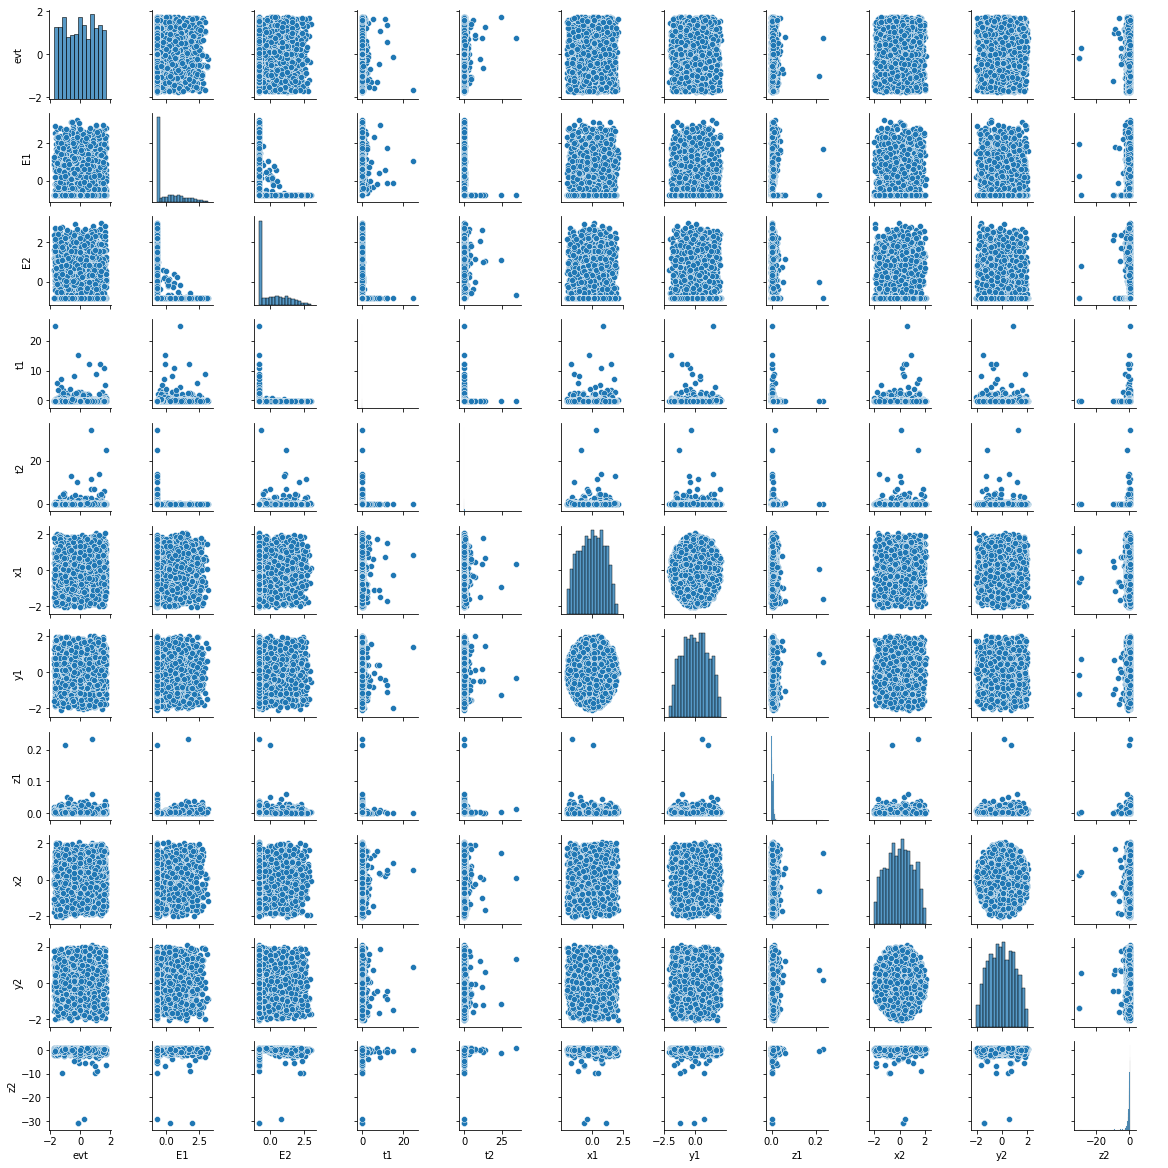

In [44]:
#let's look at the correlation matrix
sns.pairplot(data = X_std_df.sample(2000), height = 1.5)

## using cross-validation
setting up 5 cross - validation using KFold to get consisent validation dataset

In [8]:
from sklearn.model_selection import KFold
KFold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [9]:
X_train = train.drop('costh', axis = 1)
y_train = train.costh

### 1. Linear Regression

In [24]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train, y_train, cv = KFold, n_jobs = -1, scoring = 'neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-scores)
print('Linear Regression performance :', lin_rmse_scores)

Linear Regression performance : [0.37533488 0.37848598 0.37529005 0.3718378  0.373131  ]
CPU times: user 92.7 ms, sys: 109 ms, total: 201 ms
Wall time: 2.76 s


### 2. Decision Tree Regressor

In [34]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])


In [37]:
%%time
from sklearn.model_selection import KFold
KFold = KFold(n_splits = 5, shuffle = True, random_state = 42)
from sklearn.tree  import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor(random_state = 42)
scores = cross_val_score(tree_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
tree_rmse_scores = np.sqrt(-scores)
print('Decision Tree Regressor performance:', tree_rmse_scores)

Decision Tree Regressor performance: [0.39954403 0.39612888 0.39614471 0.39810222 0.395759  ]
CPU times: user 133 ms, sys: 96.2 ms, total: 229 ms
Wall time: 3.51 s


### 3. Random Forest Regressor

In [26]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = RandomForestRegressor(random_state = 42)
scores = cross_val_score(forest_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
forest_rmse_scores = np.sqrt(-scores)
print('Forest Regressor performance:', forest_rmse_scores)

Forest Regressor performance: [0.29276655 0.29282358 0.29541494 0.292738   0.2911209 ]
CPU times: user 45 ms, sys: 15.4 ms, total: 60.5 ms
Wall time: 8.55 s


### 4. LGBM

In [38]:
%%time
from lightgbm import LGBMRegressor
lgbm_reg = LGBMRegressor(random_state = 42)
scores = cross_val_score(lgbm_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
lgbm_rmse_scores = np.sqrt(-scores)
print('LGBM Regressor performance:', lgbm_rmse_scores)

LGBM Regressor performance: [0.18569321 0.18749285 0.18958336 0.18597738 0.18630572]
CPU times: user 59.4 ms, sys: 8.58 ms, total: 67.9 ms
Wall time: 2.54 s


In [28]:
%%time
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
xgb_reg = XGBRegressor(random_state = 42)
scores = cross_val_score(xgb_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
xgb_rmse_scores = np.sqrt(-scores)
print('XGB Regressor performance:', xgb_rmse_scores)

XGB Regressor performance: [0.18887261 0.19088611 0.19367501 0.18992032 0.1914682 ]
CPU times: user 41 ms, sys: 8.21 ms, total: 49.2 ms
Wall time: 12.1 s


In [10]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
cat_reg = CatBoostRegressor(random_state = 42)
scores = cross_val_score(cat_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
cat_rmse_scores = np.sqrt(-scores)
print('Cat Regressor performance:', cat_rmse_scores)

Cat Regressor performance: [0.18531834 0.18804214 0.18999499 0.18691802 0.18675719]


* smaller the MSE better the model - CatBoost , XGB, LGB Regressor works well
* we see decision tree regressor has the best score amongs other regressor fit

## Model Results

In [13]:
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(tree_reg, X_train, y_train, cv = KFold, n_jobs = -1)


NameError: name 'tree_reg' is not defined

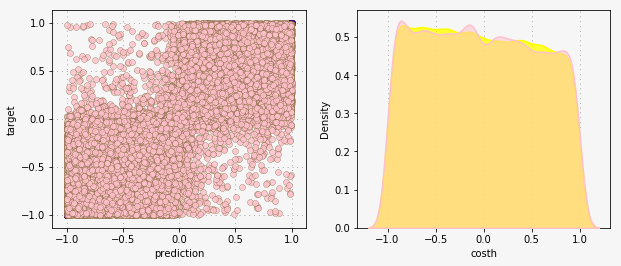

In [81]:
fig = plt.figure(figsize=(10, 4), facecolor='#f6f6f6')
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
gs.update(wspace=0.2, hspace=0)
background_color = "#f6f6f6"

sns.scatterplot(y_train, y_train, ax=ax0, color='blue', alpha = 0.7, linewidth=0.3, edgecolor='#5a0012', zorder=3)
sns.scatterplot(y_predict, y_train, ax=ax0, color='pink', alpha = 0.8,linewidth=0.3, edgecolor='#4f4100', zorder=3)

sns.kdeplot(y_train, ax=ax1, color='yellow', shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)
sns.kdeplot(y_predict, ax=ax1, color='pink', shade=True, linewidth=1.5, alpha=0.5, zorder=3, legend=False)


ax0.set_ylabel('target')
ax0.set_xlabel('prediction')
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.grid(which='major', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax1.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))




do the polynomial regression too ! 
read about what parameters can be extracted 

## Hyperparameter tuning 
to get better result using OPTUNA

In [ ]:
!pip install optuna

In [18]:
import optuna
from lightgbm import LGBMRegressor
def objective (trial):
    params ={
        'random_state':42,
        'max_depth' : int(trial.suggest_loguniform('max_depth', 1, 32)),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 20),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1.0)
    }
    lgbm_reg = LGBMRegressor()
    lgbm_reg.set_params(**params)
    scores = cross_val_score(lgbm_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
    lgbm_rmse_scores = np.sqrt(-scores)
    return np.mean(lgbm_rmse_scores)


In [19]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2022-08-26 11:05:17,309] A new study created in memory with name: no-name-c1698f5a-2f60-43f5-b8df-de00e6f12904
[I 2022-08-26 11:05:17,995] Trial 0 finished with value: 0.1873694871333193 and parameters: {'max_depth': 8.819653039042018, 'n_estimators': 18, 'learning_rate': 0.2749683863818892}. Best is trial 0 with value: 0.1873694871333193.
[I 2022-08-26 11:05:18,433] Trial 1 finished with value: 0.1959295313464985 and parameters: {'max_depth': 18.887523681598342, 'n_estimators': 5, 'learning_rate': 0.36988303584361304}. Best is trial 0 with value: 0.1873694871333193.
[I 2022-08-26 11:05:18,810] Trial 2 finished with value: 0.1907774792799119 and parameters: {'max_depth': 3.1827719622834207, 'n_estimators': 12, 'learning_rate': 0.8268805435967193}. Best is trial 0 with value: 0.1873694871333193.
[I 2022-08-26 11:05:19,114] Trial 3 finished with value: 0.24038618998785047 and parameters: {'max_depth': 2.7286604948437048, 'n_estimators': 3, 'learning_rate': 0.41668912972574773}. Best i

In [21]:
trial = study.best_trial
print('RMSE : %.3f' %(trial.value))
print('Best Hyperparameters : ', (trial.params))

RMSE : 0.187
Best Hyperparameters :  {'max_depth': 6.888823708221333, 'n_estimators': 20, 'learning_rate': 0.2560675465882839}


In [22]:
optuna.visualization.plot_optimization_history(study)

In [27]:
lgbm_reg = LGBMRegressor(max_depth= 6, n_estimators= 20, learning_rate= 0.2560675465882839, random_state=42)
lgbm_reg.fit(X_train, y_train)
l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.2560675465882839,
       max_depth=6, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
       objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent='warn', subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

feature importance using  lgbm regressor

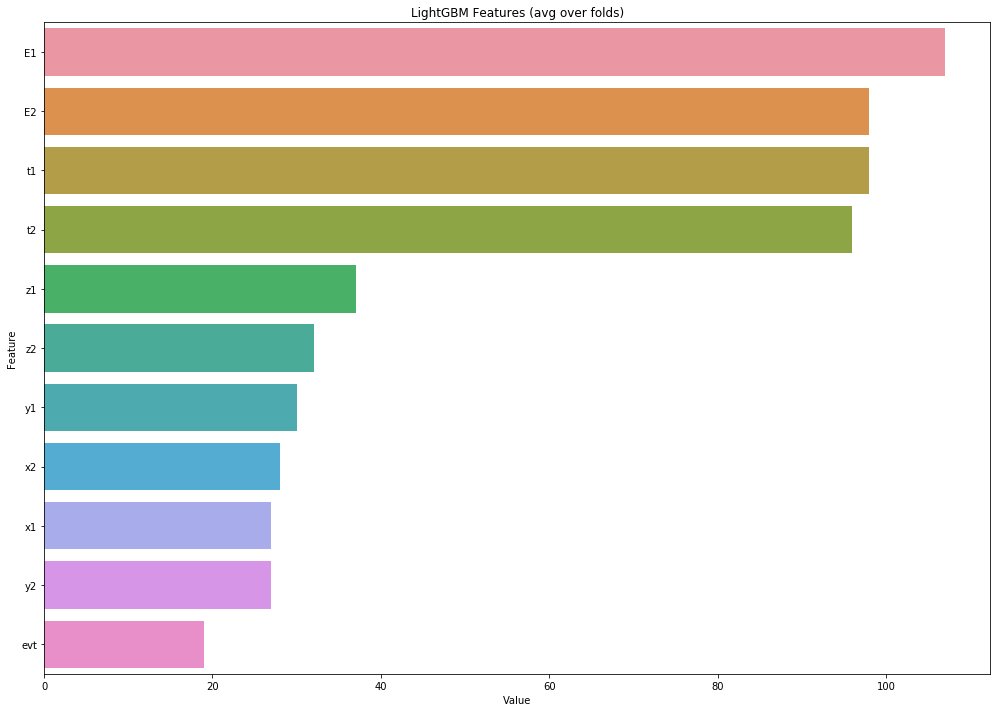

In [31]:

feature_imp = pd.DataFrame(sorted(zip(lgbm_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
plt.figure(figsize=(14,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

checkning the parameterization for CatBoostRegressos


In [15]:
def objective (trial):
    params ={
        'random_state':42,
        'depth' : int(trial.suggest_loguniform('max_depth', 1, 16)),
        'iterations' : trial.suggest_int('iterations', 2, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.01)
    }
    cat_reg = CatBoostRegressor()
    cat_reg.set_params(**params)
    scores = cross_val_score(cat_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
    lgbm_rmse_scores = np.sqrt(-scores)
    return np.mean(lgbm_rmse_scores)


In [16]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2022-08-26 10:54:40,784] A new study created in memory with name: no-name-89cd5961-ab48-46d2-9277-fb675fcff5eb
[I 2022-08-26 10:54:47,978] Trial 0 finished with value: 0.5692691236238462 and parameters: {'max_depth': 12.70323445297206, 'iterations': 2, 'learning_rate': 0.006428484089268318}. Best is trial 0 with value: 0.5692691236238462.
[I 2022-08-26 10:54:52,218] Trial 1 finished with value: 0.5540855374778446 and parameters: {'max_depth': 10.222753261380081, 'iterations': 5, 'learning_rate': 0.008865548220285239}. Best is trial 1 with value: 0.5540855374778446.
[I 2022-08-26 10:54:53,770] Trial 2 finished with value: 0.5681018506439452 and parameters: {'max_depth': 9.340828157409833, 'iterations': 7, 'learning_rate': 0.0021728125313518957}. Best is trial 1 with value: 0.5540855374778446.
[I 2022-08-26 10:54:54,170] Trial 3 finished with value: 0.572880637757134 and parameters: {'max_depth': 1.8840316341755923, 'iterations': 4, 'learning_rate': 0.0016359949340036745}. Best is tri

In [17]:
trial = study.best_trial
print('RMSE : %.3f' %(trial.value))
print('Best Hyperparameters : ', (trial.params))
optuna.visualization.plot_optimization_history(study)

RMSE : 0.529
Best Hyperparameters :  {'max_depth': 8.22184616331336, 'iterations': 10, 'learning_rate': 0.0099873209694889}
